In [77]:
import pandas as pd
import numpy as np
import hvplot.pandas
import mplcyberpunk
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
from datetime import datetime
from datetime import timezone
import pytz
style.use('cyberpunk')

In [2]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from torchmetrics import MeanAbsolutePercentageError
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [3]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
data = pd.read_csv('5Y_naver_stock.csv')
data

,date,date.1,open,high,low,close,volume,open_mean_lag3,open_mean_lag7,open_mean_lag30,...,volume_mean_lag7,volume_mean_lag30,volume_std_lag3,volume_std_lag7,volume_std_lag30,month,week,day,day_of_week,1st diff_close
0,2018-03-14 00:00:00+09:00,2018-03-14 00:00:00+09:00,162600.0,162800.0,160200.0,161800.0,376640,236843.414634,236773.234611,236267.715622,...,666136.903417,666569.359165,202316.644360,250432.425607,327866.104382,3,11,14,2,NaN
1,2018-03-15 00:00:00+09:00,2018-03-15 00:00:00+09:00,162600.0,164800.0,161400.0,164000.0,341525,162600.000000,162600.000000,162600.000000,...,376640.000000,376640.000000,202316.644360,250432.425607,327866.104382,3,11,15,3,2200.0
2,2018-03-16 00:00:00+09:00,2018-03-16 00:00:00+09:00,163200.0,163400.0,159400.0,160200.0,717990,162600.000000,162600.000000,162600.000000,...,359082.500000,359082.500000,24830.054621,24830.054621,24830.054621,3,11,16,4,-3800.0
3,2018-03-19 00:00:00+09:00,2018-03-19 00:00:00+09:00,160200.0,160400.0,156400.0,157000.0,600070,162800.000000,162800.000000,162800.000000,...,478718.333333,478718.333333,207957.841060,207957.841060,207957.841060,3,12,19,0,-3200.0
4,2018-03-20 00:00:00+09:00,2018-03-20 00:00:00+09:00,155400.0,159200.0,154800.0,159000.0,441955,162000.000000,162150.000000,162150.000000,...,509056.250000,509056.250000,192560.180918,180312.319388,180312.319388,3,12,20,1,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226,2023-03-08 00:00:00+09:00,2023-03-08 00:00:00+09:00,208500.0,209000.0,202000.0,202500.0,1027023,210000.000000,209214.285714,213483.333333,...,717810.142857,198773.433333,216749.843973,340774.092545,359135.196561,3,10,8,2,-8500.0
1227,2023-03-09 00:00:00+09:00,2023-03-09 00:00:00+09:00,204500.0,206000.0,202000.0,202000.0,760330,210333.333333,208500.000000,213916.666667,...,863654.285714,206744.833333,230988.383163,151090.197192,374967.029167,3,10,9,3,-500.0
1228,2023-03-10 00:00:00+09:00,2023-03-10 00:00:00+09:00,198000.0,201000.0,197800.0,199800.0,854741,209000.000000,208571.428571,214050.000000,...,839349.000000,231935.000000,198008.065170,152231.308080,386138.071194,3,10,10,4,-2200.0
1229,2023-03-13 00:00:00+09:00,2023-03-13 00:00:00+09:00,199800.0,203000.0,194600.0,202500.0,1035513,203666.666667,206928.571429,213900.000000,...,840265.857143,260254.500000,135228.005417,152313.669531,399843.696492,3,11,13,0,2700.0


In [5]:
# enable GPU processing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device type: {device}')

Device type: cuda


In [6]:
data['date'] = data['date'].apply(pd.to_datetime)
data['date'] = data['date'].dt.tz_localize(None)
data = data.set_index(data['date'])
data.drop(['date.1', 'date'], axis=1, inplace=True)

In [7]:
data

,open,high,low,close,volume,open_mean_lag3,open_mean_lag7,open_mean_lag30,open_std_lag3,open_std_lag7,...,volume_mean_lag7,volume_mean_lag30,volume_std_lag3,volume_std_lag7,volume_std_lag30,month,week,day,day_of_week,1st diff_close
date,,,,,,,,,,,,,,,,,,,,,
2018-03-14,162600.0,162800.0,160200.0,161800.0,376640,236843.414634,236773.234611,236267.715622,3524.453377,5136.693375,...,666136.903417,666569.359165,202316.644360,250432.425607,327866.104382,3,11,14,2,NaN
2018-03-15,162600.0,164800.0,161400.0,164000.0,341525,162600.000000,162600.000000,162600.000000,3524.453377,5136.693375,...,376640.000000,376640.000000,202316.644360,250432.425607,327866.104382,3,11,15,3,2200.0
2018-03-16,163200.0,163400.0,159400.0,160200.0,717990,162600.000000,162600.000000,162600.000000,0.000000,0.000000,...,359082.500000,359082.500000,24830.054621,24830.054621,24830.054621,3,11,16,4,-3800.0
2018-03-19,160200.0,160400.0,156400.0,157000.0,600070,162800.000000,162800.000000,162800.000000,346.410162,346.410162,...,478718.333333,478718.333333,207957.841060,207957.841060,207957.841060,3,12,19,0,-3200.0
2018-03-20,155400.0,159200.0,154800.0,159000.0,441955,162000.000000,162150.000000,162150.000000,1587.450787,1330.413470,...,509056.250000,509056.250000,192560.180918,180312.319388,180312.319388,3,12,20,1,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-08,208500.0,209000.0,202000.0,202500.0,1027023,210000.000000,209214.285714,213483.333333,3500.000000,3533.849917,...,717810.142857,198773.433333,216749.843973,340774.092545,359135.196561,3,10,8,2,-8500.0
2023-03-09,204500.0,206000.0,202000.0,202000.0,760330,210333.333333,208500.000000,213916.666667,3175.426481,2986.078811,...,863654.285714,206744.833333,230988.383163,151090.197192,374967.029167,3,10,9,3,-500.0
2023-03-10,198000.0,201000.0,197800.0,199800.0,854741,209000.000000,208571.428571,214050.000000,4769.696007,2863.979915,...,839349.000000,231935.000000,198008.065170,152231.308080,386138.071194,3,10,10,4,-2200.0


In [8]:
# close에 알맞는 변수 리스트
exogenous_features = ['open_mean_lag3',
                      'open_mean_lag7', 'open_mean_lag30', 'open_std_lag3', 'open_std_lag7',
                      'open_std_lag30', 'high_mean_lag3', 'high_mean_lag7', 'high_mean_lag30',
                      'high_std_lag3', 'high_std_lag7', 'high_std_lag30', 'low_mean_lag3',
                      'low_mean_lag7', 'low_mean_lag30', 'low_std_lag3', 'low_std_lag7',
                      'low_std_lag30', 'close_mean_lag3', 'close_mean_lag7',
                      'close_mean_lag30', 'close_std_lag3', 'close_std_lag7',
                      'close_std_lag30', 'volume_mean_lag3', 'volume_mean_lag7',
                      'volume_mean_lag30', 'volume_std_lag3',
                      'volume_std_lag7', 'volume_std_lag30', 'month', 'week',
                      'day', 'day_of_week','volume']

In [9]:
data = data[exogenous_features + ['close']] 
data["prev_close"] = data.shift(1)["close"]
data["close_change"] = data.apply(lambda row: 0  if np.isnan(row.prev_close) else row.close - row.prev_close,
                                   axis = 1)
data.drop('prev_close', axis=1, inplace=True)

C:\Users\Lee\AppData\Local\Temp\ipykernel_10544\2514338433.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["prev_close"] = data.shift(1)["close"]
C:\Users\Lee\AppData\Local\Temp\ipykernel_10544\2514338433.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["close_change"] = data.apply(lambda row: 0  if np.isnan(row.prev_close) else row.close - row.prev_close,
C:\Users\Lee\AppData\Local\Temp\ipykernel_10544\2514338433.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [10]:
# 결측치확인
def missing(df):
    if df.isnull().values.any():
        print("Missing values:\n")
    else:
        print("no missing values\n")
missing(data)  

no missing values



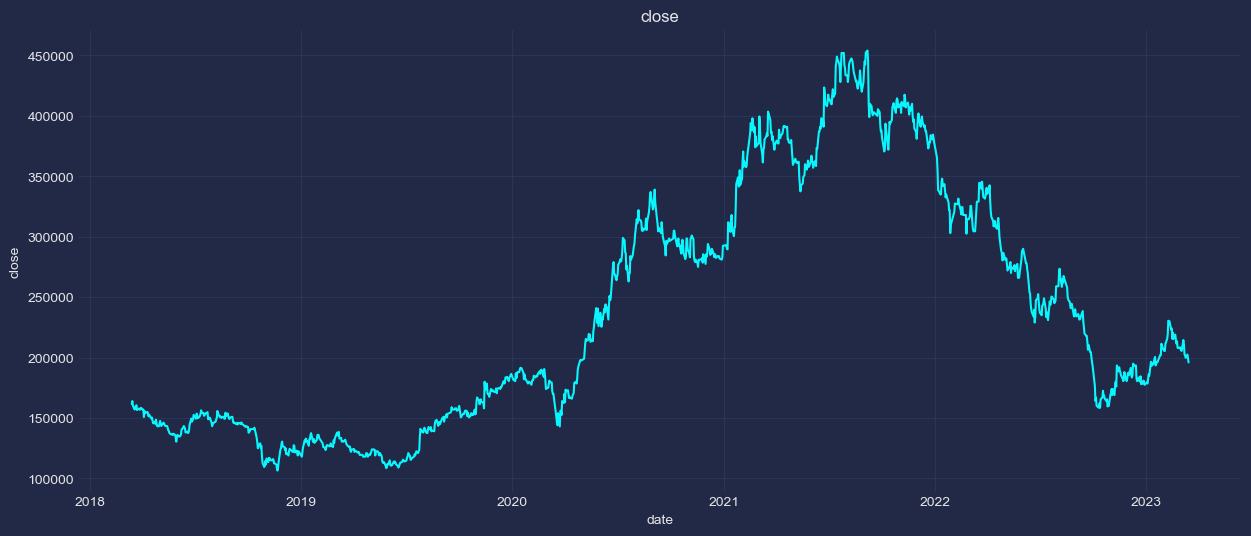

In [11]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.color_palette("tab10")
sns.lineplot(data=data, x=data.index, y='close', legend='full')
ax.set_xlabel("date")
ax.set_ylabel("close")
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax.set_title(label = "close");

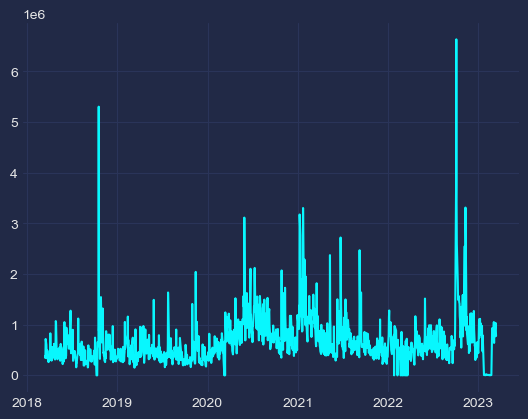

In [12]:
plt.plot(data.volume)
plt.show()

In [13]:
data.columns

Index(['open_mean_lag3', 'open_mean_lag7', 'open_mean_lag30', 'open_std_lag3',
       'open_std_lag7', 'open_std_lag30', 'high_mean_lag3', 'high_mean_lag7',
       'high_mean_lag30', 'high_std_lag3', 'high_std_lag7', 'high_std_lag30',
       'low_mean_lag3', 'low_mean_lag7', 'low_mean_lag30', 'low_std_lag3',
       'low_std_lag7', 'low_std_lag30', 'close_mean_lag3', 'close_mean_lag7',
       'close_mean_lag30', 'close_std_lag3', 'close_std_lag7',
       'close_std_lag30', 'volume_mean_lag3', 'volume_mean_lag7',
       'volume_mean_lag30', 'volume_std_lag3', 'volume_std_lag7',
       'volume_std_lag30', 'month', 'week', 'day', 'day_of_week', 'volume',
       'close', 'close_change'],
      dtype='object')

In [14]:
# check correlation of features with close price
corr = data.corr(method='pearson')
close_corr = pd.DataFrame(corr['close'].sort_values(ascending=False))
print(close_corr)

                      close
close              1.000000
close_mean_lag3    0.997446
high_mean_lag3     0.997168
low_mean_lag3      0.997016
open_mean_lag3     0.996782
close_mean_lag7    0.995746
high_mean_lag7     0.995582
low_mean_lag7      0.995255
open_mean_lag7     0.995151
high_mean_lag30    0.983141
close_mean_lag30   0.982841
open_mean_lag30    0.982149
low_mean_lag30     0.981741
high_std_lag30     0.581206
close_std_lag30    0.578443
open_std_lag30     0.570770
close_std_lag7     0.555808
low_std_lag30      0.555357
high_std_lag7      0.545836
open_std_lag7      0.536385
low_std_lag7       0.518720
high_std_lag3      0.467177
close_std_lag3     0.460543
open_std_lag3      0.447836
low_std_lag3       0.433032
volume_mean_lag30  0.370143
volume_mean_lag7   0.242337
volume_mean_lag3   0.206270
volume             0.171536
volume_std_lag30   0.080938
volume_std_lag3    0.067274
volume_std_lag7    0.063101
close_change       0.024727
month              0.011827
day_of_week        0

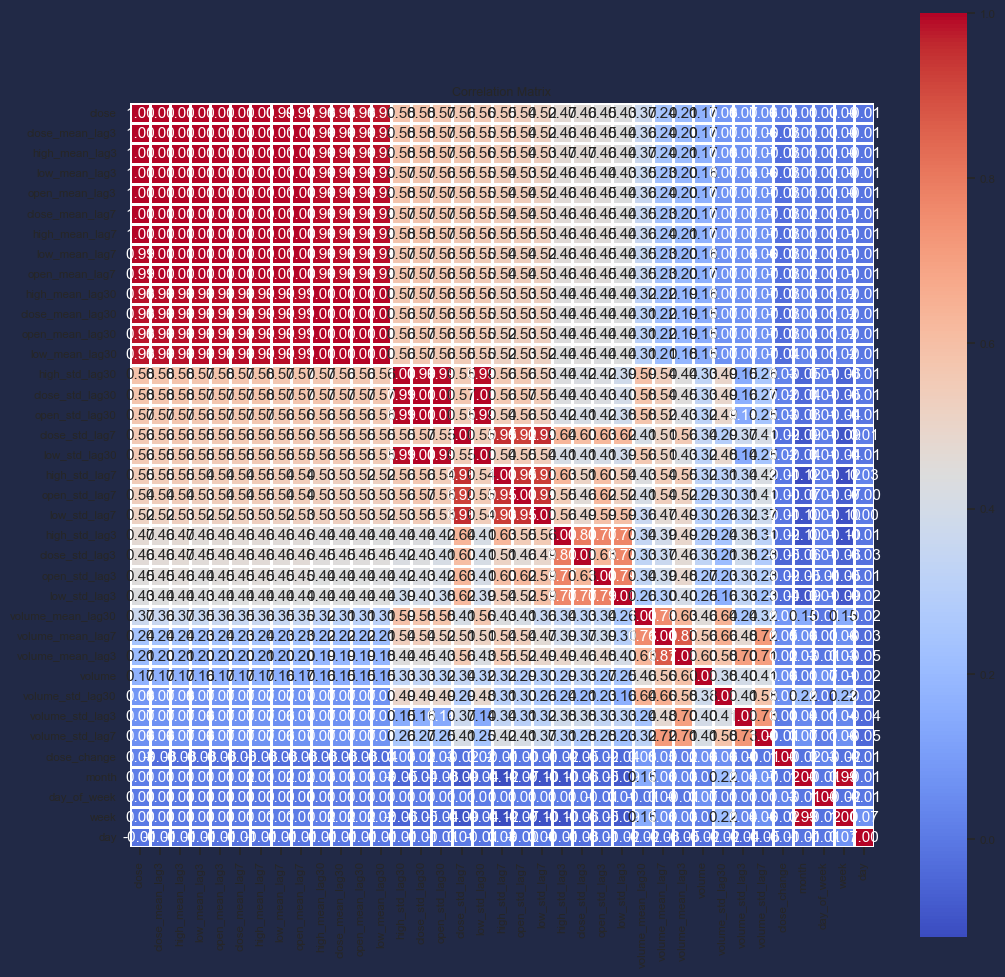

In [15]:
# correlation matrix
corr_idx = data.corr().sort_values("close", ascending=False).index
corr_sorted = data.loc[:, corr_idx]  

plt.figure(figsize = (12,12))
sns.set(font_scale=0.75)
ax = sns.heatmap(corr_sorted.corr().round(3), annot=True, square=True, linewidths=.75, 
                 cmap="coolwarm", fmt = ".2f", annot_kws = {"size": 11})
ax.xaxis.tick_bottom()
plt.title("Correlation Matrix")
plt.show()

Prepare Data for TFT Model

In [16]:
data.reset_index(inplace=True)
x1 = range(1, data.shape[0]+1 , 1)

data['idx'] = x1
data['naver'] = 1 #그룹 아이디

lookback = 120
all_prediction_length = 124
prediction_length = 1


#학습할 데이터 및 label
train_data = data["idx"].max() - all_prediction_length
train_set = data[data.idx <=train_data]
val_set = data[data.idx <=train_data+ 1]

C:\Users\Lee\AppData\Local\Temp\ipykernel_10544\2911829146.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['idx'] = x1


In [17]:
data.columns

Index(['date', 'open_mean_lag3', 'open_mean_lag7', 'open_mean_lag30',
       'open_std_lag3', 'open_std_lag7', 'open_std_lag30', 'high_mean_lag3',
       'high_mean_lag7', 'high_mean_lag30', 'high_std_lag3', 'high_std_lag7',
       'high_std_lag30', 'low_mean_lag3', 'low_mean_lag7', 'low_mean_lag30',
       'low_std_lag3', 'low_std_lag7', 'low_std_lag30', 'close_mean_lag3',
       'close_mean_lag7', 'close_mean_lag30', 'close_std_lag3',
       'close_std_lag7', 'close_std_lag30', 'volume_mean_lag3',
       'volume_mean_lag7', 'volume_mean_lag30', 'volume_std_lag3',
       'volume_std_lag7', 'volume_std_lag30', 'month', 'week', 'day',
       'day_of_week', 'volume', 'close', 'close_change', 'idx', 'naver'],
      dtype='object')

In [18]:

training = TimeSeriesDataSet(train_set, time_idx="idx", target="close", group_ids=["naver"], 
                             min_encoder_length=lookback // 2, max_encoder_length=lookback, min_prediction_length=1, 
                             max_prediction_length=prediction_length, time_varying_known_reals=["idx", "day",'day_of_week','month', 'week'],
                             time_varying_unknown_reals=['open_mean_lag3', 'open_mean_lag7', 'open_mean_lag30',
       'open_std_lag3', 'open_std_lag7', 'open_std_lag30', 'high_mean_lag3',
       'high_mean_lag7', 'high_mean_lag30', 'high_std_lag3', 'high_std_lag7',
       'high_std_lag30', 'low_mean_lag3', 'low_mean_lag7', 'low_mean_lag30',
       'low_std_lag3', 'low_std_lag7', 'low_std_lag30', 'close_mean_lag3',
       'close_mean_lag7', 'close_mean_lag30', 'close_std_lag3',
       'close_std_lag7', 'close_std_lag30', 'volume_mean_lag3',
       'volume_mean_lag7', 'volume_mean_lag30', 'volume_std_lag3',
       'volume_std_lag7', 'volume_std_lag30',
        'volume', 'close', 'close_change',],
                             add_relative_time_idx=True, 
                             add_target_scales=True, add_encoder_length=True)

validation = TimeSeriesDataSet.from_dataset(training, val_set, predict=True, stop_randomization=True)

In [19]:
#데이터 로더
batch_size = 16
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=1)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=1)

In [20]:
#early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()
epochs = 40
trainer = pl.Trainer(max_epochs=epochs, accelerator='gpu', devices=1, enable_model_summary=True, gradient_clip_val=0.1, 
                     callbacks=[lr_logger])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
tft = TemporalFusionTransformer.from_dataset(training, learning_rate=0.001, hidden_size=256, attention_head_size=4, 
                                             dropout=0.1, hidden_continuous_size=256,
                                             output_size=7, loss=QuantileLoss(), reduce_on_plateau_patience=10)

c:\Users\Lee\.conda\envs\mecab\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\Lee\.conda\envs\mecab\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [22]:
# fit the model to the training data
trainer.fit(tft, 
            train_dataloaders=train_dataloader, 
            val_dataloaders=val_dataloader)

You are using a CUDA device ('NVIDIA GeForce RTX 3050') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 21.5 K
4  | static_variable_selection          | VariableSelectionNetwork        | 794 K 
5  | e

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\Lee\.conda\envs\mecab\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\Lee\.conda\envs\mecab\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


In [23]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)

c:\Users\Lee\Desktop\개인프로젝트\Timeseries\프로젝트\lightning_logs\version_507\checkpoints\epoch=39-step=2760.ckpt


In [24]:
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [25]:
# evaluate predictions vs. actuals
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"))

c:\Users\Lee\.conda\envs\mecab\lib\site-packages\lightning\pytorch\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
c:\Users\Lee\.conda\envs\mecab\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


In [26]:
print(predictions)
print(actuals)
print(actuals.shape)

tensor([[237675.5625]])
tensor([[230000.]])
torch.Size([1, 1])


In [27]:
# predict on the validation set
raw_predictions= best_tft.predict(val_dataloader, mode="raw", return_x=True)
print('prediction shape:', raw_predictions[0]['prediction'].shape)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


prediction shape: torch.Size([1, 1, 7])


c:\Users\Lee\.conda\envs\mecab\lib\site-packages\pytorch_forecasting\models\base_model.py:1039: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plotter(x_pred, y[-n_pred:], label=None, c=obs_color)
c:\Users\Lee\.conda\envs\mecab\lib\site-packages\pytorch_forecasting\models\base_model.py:1042: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plotter(x_pred, y_hat, label="predicted", c=pred_color)
c:\Users\Lee\.conda\envs\mecab\lib

ValueError: 'yerr' must not contain negative values

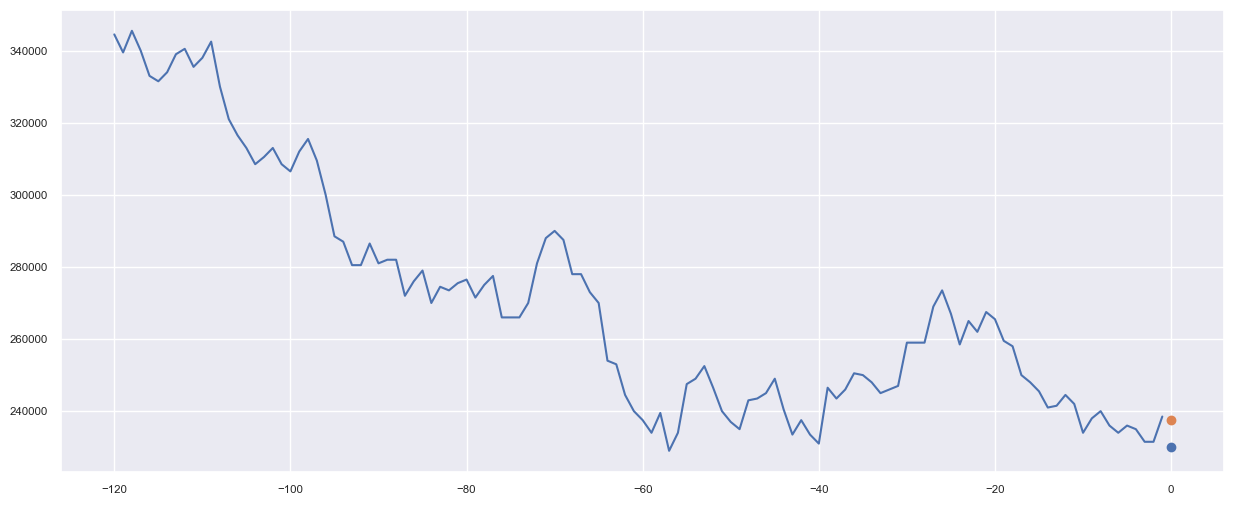

In [28]:
fig, ax = plt.subplots(figsize=(15, 6))
best_tft.plot_prediction(raw_predictions.x, raw_predictions[0], idx=0, ax=ax);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Lee\.conda\envs\mecab\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


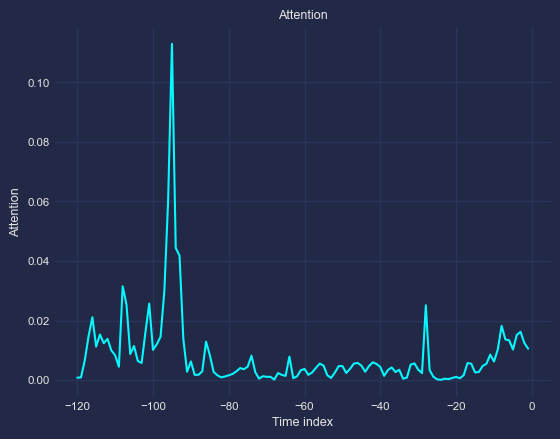

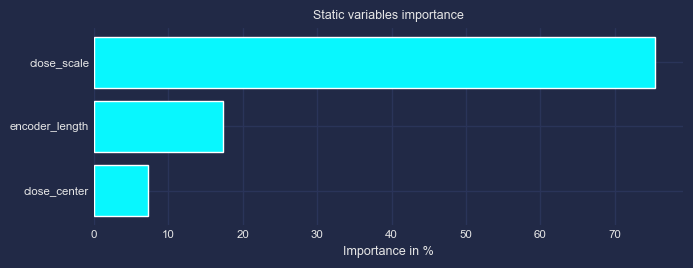

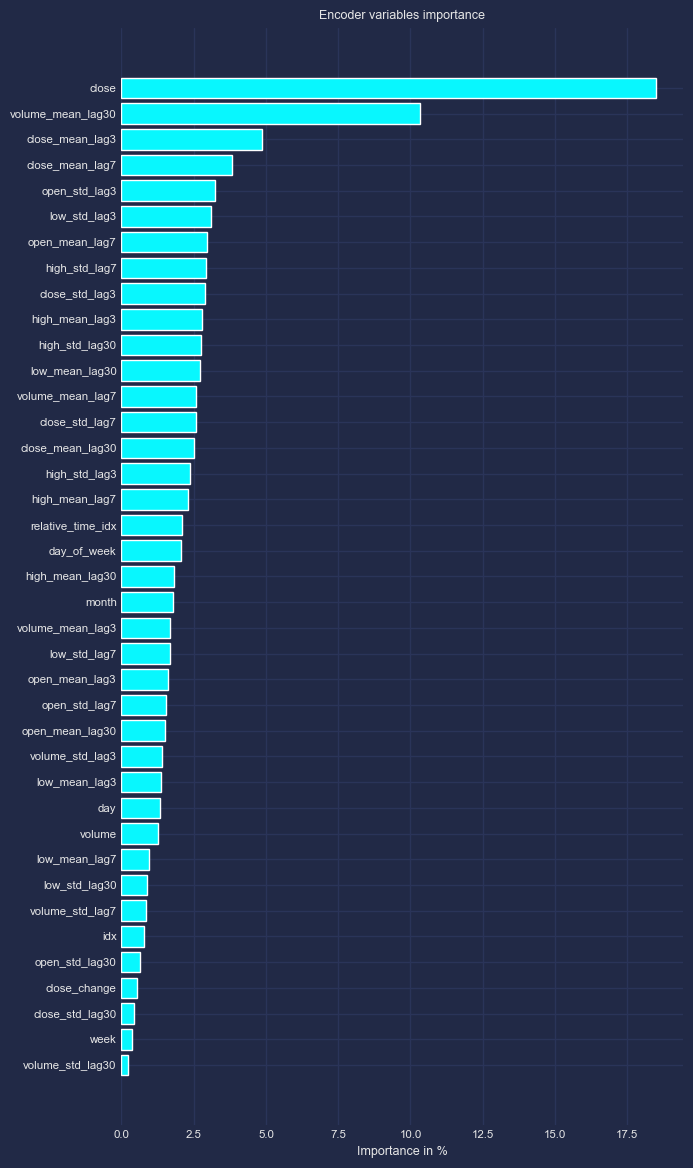

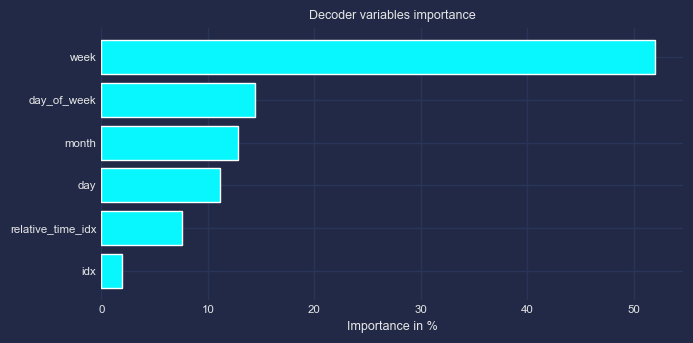

In [39]:
# feature level interpretability
raw_predictions= best_tft.predict(val_dataloader, mode="raw", return_x=True)
interpretation = best_tft.interpret_output(raw_predictions[0], reduction="sum")
best_tft.plot_interpretation(interpretation);

In [30]:
#test 데이터셋
SEQUENCE_LENGTH = 120
split_ratio = 0.9

test_size = int(len(data) * split_ratio)

test_df = data[test_size-SEQUENCE_LENGTH:]
print("테스트 데이터셋 shape: ", test_df.shape)

#예측할 데이터 셋
all_predict_data = test_df[test_df.idx > test_df.idx.max() - all_prediction_length]

테스트 데이터셋 shape:  (244, 40)


In [31]:
def tft_predict(test_df, all_predict_data):

    predicts = []
    for i in range(len(all_predict_data)):
        encoder_data = test_df.iloc[i :SEQUENCE_LENGTH + i] # 120 시퀀스 데이터
        last_data = encoder_data.iloc[-1:].copy() #마지막 데이터 추출 및 복사
        
        target_data = all_predict_data.iloc[i : i + 1].copy()

        last_data['idx'] = target_data.iloc[0]['idx']
        last_data['day'] = target_data.iloc[0]['day']
        last_data['month'] = target_data.iloc[0]['month']
        last_data['week'] = target_data.iloc[0]['week']
        last_data['day_of_week'] = target_data.iloc[0]['day_of_week']

        #인코더,디코더 입력부분 합치기
        new_pred_data = pd.concat([encoder_data, last_data], ignore_index=True)
        #모델 예측
        predict = best_tft.predict(new_pred_data, trainer_kwargs=dict(accelerator="cpu"))
        predicts.append(predict.numpy()[0].squeeze())

    return predicts


In [ ]:
predicted_data = tft_predict(test_df, all_predict_data)

In [ ]:
all_predict_data['prediction'] = predicted_data
all_predict_data['prediction'] = all_predict_data['prediction'].astype('float')

<Axes: >

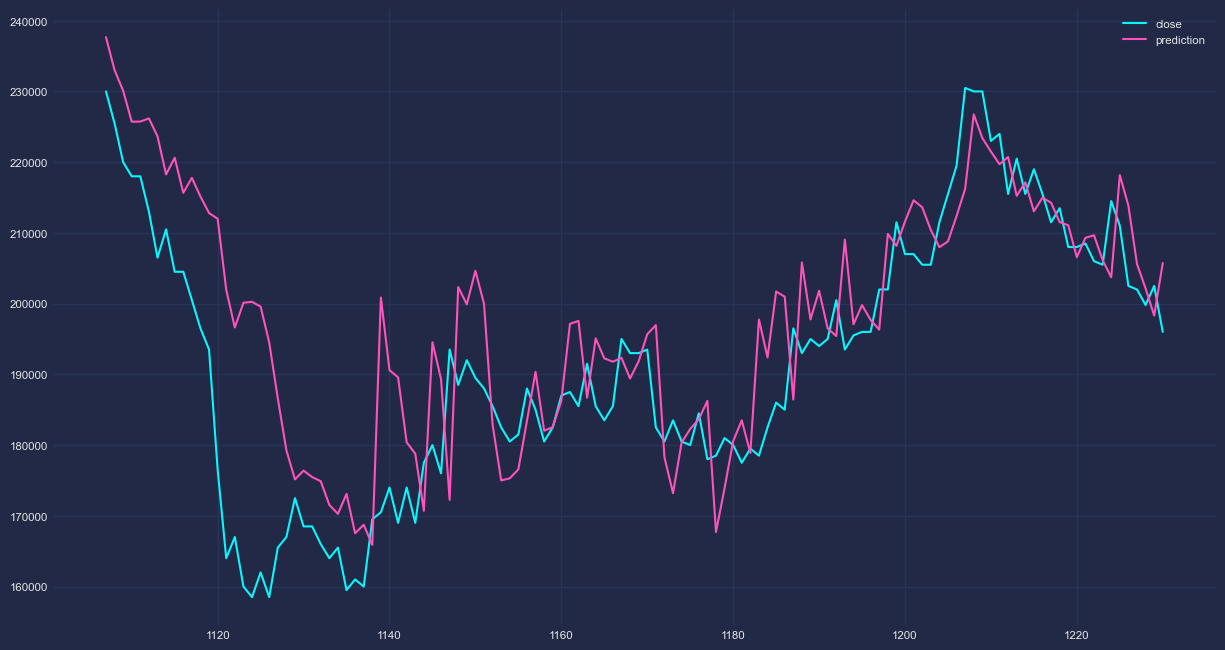

In [36]:
all_predict_data[["close", "prediction"]].plot(figsize=(15, 8))

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [38]:
test_mae_tft = mean_absolute_error(all_predict_data['close'].values, all_predict_data['prediction'])
test_rmse_tft = np.sqrt(mean_squared_error(all_predict_data['close'].values, all_predict_data['prediction']))
test_r2_tft = r2_score(all_predict_data['close'].values, all_predict_data['prediction'])

print(f"test MAE test_mae_tft  : {round(test_mae_tft, 2)}")
print(f"test RMSE test_rmse_tft : {round(test_rmse_tft, 2)}")
print(f"test R2 test_r2_tft: {round(test_r2_tft, 2)}")

test MAE test_mae_tft  : 9392.14
test RMSE test_rmse_tft : 12839.28
test R2 test_r2_tft: 0.52


In [58]:
eval_scores = pd.DataFrame([[round(test_mae_tft, 2),round(test_rmse_tft,2), round(test_r2_tft,2)]],
                            index=['TFT'],
                            columns = ['MAE', 'RMSE', 'R2'])
eval_scores.reset_index(inplace=True)

eval_scores.rename(columns={'index':'Model'}, inplace=True)
eval_scores

,Model,MAE,RMSE,R2
0,tft,9392.14,12839.28,0.52


In [59]:
#저장
eval_scores_table = pd.read_csv('eval_scores.csv')
eval_scores_table = eval_scores_table.iloc[:5]
cat_eval = pd.concat([eval_scores_table, eval_scores],ignore_index=True)
cat_eval.to_csv('eval_scores.csv')

In [78]:
cat_eval

,Model,MAE,RMSE,R2
0,ARIMA,50678.47,53566.43,-7.42
1,Prophet,7555.16,9610.24,0.73
2,XGBRegressor,10645.59,14629.09,0.37
3,LSTM,6591.59,8452.08,0.79
4,Transformer,12851.38,16099.68,0.24
5,TFT,9392.14,12839.28,0.52


<Axes: xlabel='Model'>

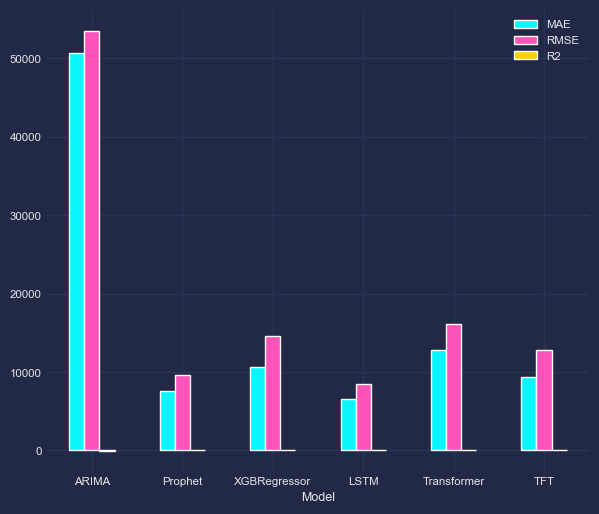

In [74]:
cat_eval.set_index('Model').plot(kind="bar",figsize=(7,6), rot=0)

<Axes: >

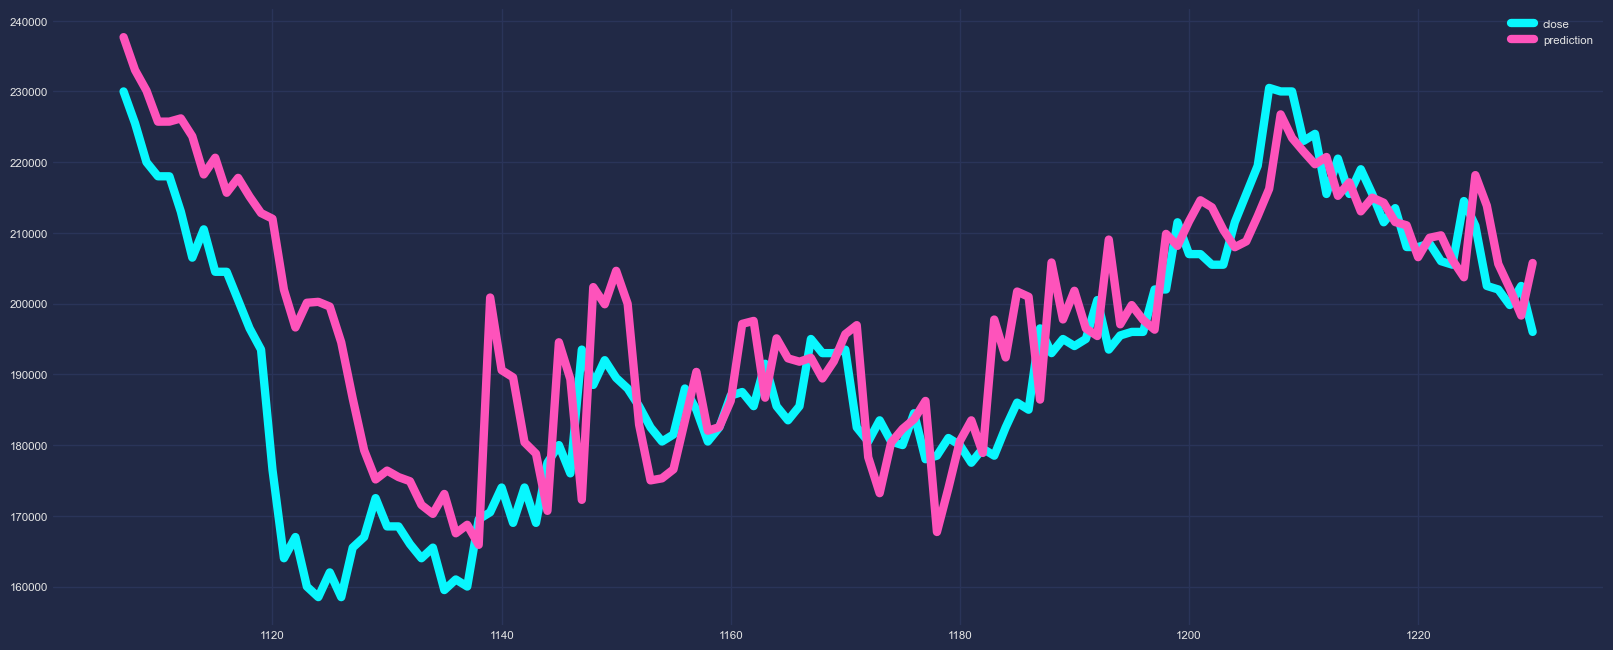

In [56]:
all_predict_data[["close", "prediction"]].plot(figsize=(20, 8), linewidth="6")